In [1]:
# data from  https://catalog.data.gov/dataset/consumer-complaint-database

In [2]:
# !unzip ../data/complaints.csv.zip

# Application of TF-IDF technique for text categorization
In this notebook we test the methode of TF-IDF feature to do text categorization. The text data will be bank complaints and we will aim to sort them between different products.

As the TF-IDF methode only allow to vectorize the text data we will still need to apply a machine learning algorithm on it.
We will test the following algorithm :
- Random Forest
- Linear SVC
- Multinomial Naive Bayesian
- Logistic Regression

## Imports
We will use:
- pandas and numpy for data handling
- seaborn and matplotlib for visualisation
- sklearn for feature generation, modeling and metrics

In [3]:
# Input data files are available in the "../data/" directory.
import os
print(os.listdir("../data"))

import pandas as pd
import numpy as np

import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from io import StringIO

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


['complaints.csv', '.ipynb_checkpoints']


In [4]:
os.getcwd()

'/home/jupyter/nlp/src'

## Data Loading 
We didn't load the whole dataframe as some lines from the zip file were corupted. We still ended up with more than 600K lines, which is more than enough for our usecase.

In [5]:
# loading data
complaints_df_v0 = pd.read_csv('../data/complaints.csv')
complaints_df_v0.shape

(626953, 18)

In [6]:
complaints_df_v0.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
3,2021-04-14,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,NaN,NaN,ENCORE CAPITAL GROUP INC.,VA,238XX,NaN,NaN,Web,2021-04-14,Closed with explanation,Yes,NaN,4295157
4,2021-04-21,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,NaN,Company believes it acted appropriately as aut...,"Choice Recovery, Inc.",FL,322XX,NaN,NaN,Web,2021-04-21,Closed with explanation,Yes,NaN,4315858


## Data cleaning and filtering

#### Remove unnecessary columns to keep only the text and the product

In [7]:
# Create a new dataframe with two columns
complaints_df_v1 = complaints_df_v0[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
complaints_df_v1 = complaints_df_v1[pd.notnull(complaints_df_v1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
complaints_df_v1.columns = ['Product', 'Consumer_complaint'] 

complaints_df_v1.shape

(259332, 2)

##### Quick look at the distribution of the complaints lenght

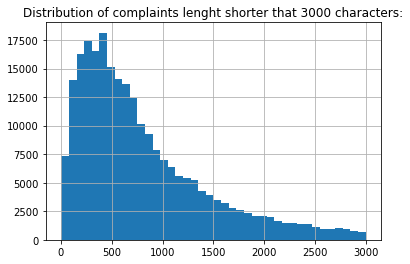

Minimum number of character per complaints :  4


In [9]:
complaints_lenghts = complaints_df_v1.Consumer_complaint.apply(len)
plt.title("Distribution of complaints lenght shorter that 3000 characters:")
complaints_lenghts[complaints_lenghts < 3000].hist(bins=40)
plt.show()
print("Minimum number of character per complaints : ", complaints_lenghts.min())

#### Rename the products categories to make it easier to use 

In [11]:
# Renaming categories
complaints_df_v1.replace({'Product': 
                          {'Credit reporting, credit repair services, or other personal consumer reports': 
                           'Credit reporting, repair, or other', 
                           'Credit reporting': 'Credit reporting, repair, or other',
                          'Credit card': 'Credit card or prepaid card',
                          'Prepaid card': 'Credit card or prepaid card',
                          'Payday loan': 'Payday loan, title loan, or personal loan',
                          'Money transfer': 'Money transfer, virtual currency, or money service',
                          'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
                         inplace=True)

#### Select only the significant categories (with at least 1000 example in the whole dataset

In [12]:
important_product_value_counts = complaints_df_v1.Product.value_counts()[complaints_df_v1.Product.value_counts() > 1000]
important_product = important_product_value_counts.index
important_product_value_counts

Credit reporting, repair, or other                    133453
Debt collection                                        44311
Credit card or prepaid card                            25388
Mortgage                                               19527
Checking or savings account                            14195
Money transfer, virtual currency, or money service      6690
Vehicle loan or lease                                   5860
Student loan                                            5645
Payday loan, title loan, or personal loan               4173
Name: Product, dtype: int64

In [13]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
complaints_df = complaints_df_v1[complaints_df_v1.Product.isin(important_product)].sample(10000, random_state=1).copy()

In [14]:
pd.DataFrame(complaints_df.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Mortgage
3,Vehicle loan or lease
4,Credit card or prepaid card
5,"Money transfer, virtual currency, or money ser..."
6,"Payday loan, title loan, or personal loan"
7,Checking or savings account
8,Student loan


#### Create category ID

In [15]:
#  Create a new column 'category_id' with encoded categories 
complaints_df['category_id'] = complaints_df['Product'].factorize()[0]
category_id_df = complaints_df[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
complaints_df.head()

,Product,Consumer_complaint,category_id
358973,"Credit reporting, repair, or other",XXXX XXXX XXXX - Their name is listed on my Ex...,0
465918,"Credit reporting, repair, or other",XX/XX/2020 I called because I had received a l...,0
248251,Debt collection,I owed a credit card debt with XXXX XXXX which...,1
493781,Mortgage,We are refinancing our loan and the bank that ...,2
180003,"Credit reporting, repair, or other",HAVE CONTACTED THE CREDIT BUREAUS ON NUMEROUS ...,0


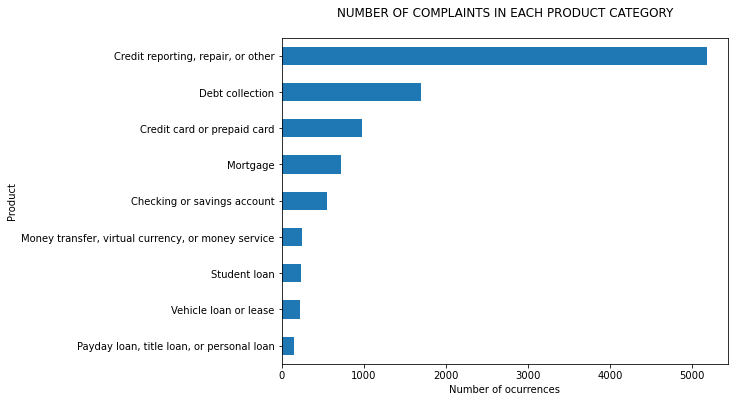

In [17]:
fig = plt.figure(figsize=(8,6))
complaints_df.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

## TF-IDF 

TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

##### Term Frequency:

$$TF  = \frac{NTD}{NWD}$$

with:

- NTD: The number of times the word appear in the document.
- NWD: The total number of words in the docuemnt.

##### Inverted Docuement Frequency:

$$IDF  = ln(\frac{ND}{NDT})$$

with:

- ND: The total number of documents.
- NWD: The number of documents containing the term.

##### TFIDF:

$$ TF-IDF = \frac{TF}{IDF}$$

In [20]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(complaints_df.Consumer_complaint).toarray()

labels = complaints_df.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26620 features (TF-IDF score of unigrams and bigrams)


## Check the top 5 words which are the most correlated with each product

In [22]:
# Finding the three most correlated terms with each of the product categories
N = 5
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Checking or savings account:
  * Most Correlated Unigrams are: overdraft, branch, checking, bank, deposit
  * Most Correlated Bigrams are: debit card, 00 bonus, overdraft fees, savings account, checking account

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: charges, synchrony, citi, express, card
  * Most Correlated Bigrams are: new card, use card, synchrony bank, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: equifax, reporting, experian, report, accounts
  * Most Correlated Bigrams are: fraudulent accounts, victim identity, credit bureaus, identity theft, credit report

==> Debt collection:
  * Most Correlated Unigrams are: owe, recovery, collect, collection, debt
  * Most Correlated Bigrams are: debt collector, debt collection, debt does, collection agency, collect debt

==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: cash, app, cashapp, coinbase, paypal
  * 

## Train the models
### Split train and test sets

In [23]:
X = complaints_df['Consumer_complaint'] # Collection of documents
y = complaints_df['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

### Build and train models

To estimate the models performance we use a cross validation with 5 folds.

In [24]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Model performance visualisation

For each model we compute and visualise the average model accuracy and the standard deviation over the 5 folds.

In [28]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8259,0.001851
LogisticRegression,0.8062,0.004251
MultinomialNB,0.6388,0.007488
RandomForestClassifier,0.5176,0.000418


### Best model detailed performances

As the Linear support vector classifier has the best performance in terms of accuracy,
we retrain it and retest it on 25% percent of the dataset and look into the details of its prediction.

In [29]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               complaints_df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Detailed performance analysis 

We look for each of the product the follwoing metrics:
- precision
- recall
- f1-score

We also compute the macro average as well as the weighted average for each of those metrics over the whole test set.

In [30]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= complaints_df['Product'].unique()))

				CLASSIFICATIION METRICS

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.85      0.93      0.89      1261
                                   Debt collection       0.80      0.75      0.77       433
                                          Mortgage       0.84      0.86      0.85       179
                             Vehicle loan or lease       0.79      0.42      0.55        62
                       Credit card or prepaid card       0.74      0.74      0.74       250
Money transfer, virtual currency, or money service       0.67      0.50      0.57        58
         Payday loan, title loan, or personal loan       0.80      0.17      0.28        48
                       Checking or savings account       0.66      0.69      0.68       141
                                      Student loan       0.88      0.62      0.72        68

                                          accurac

### Confusion matrix

We visualise the confusion matrix of the model on the test set.

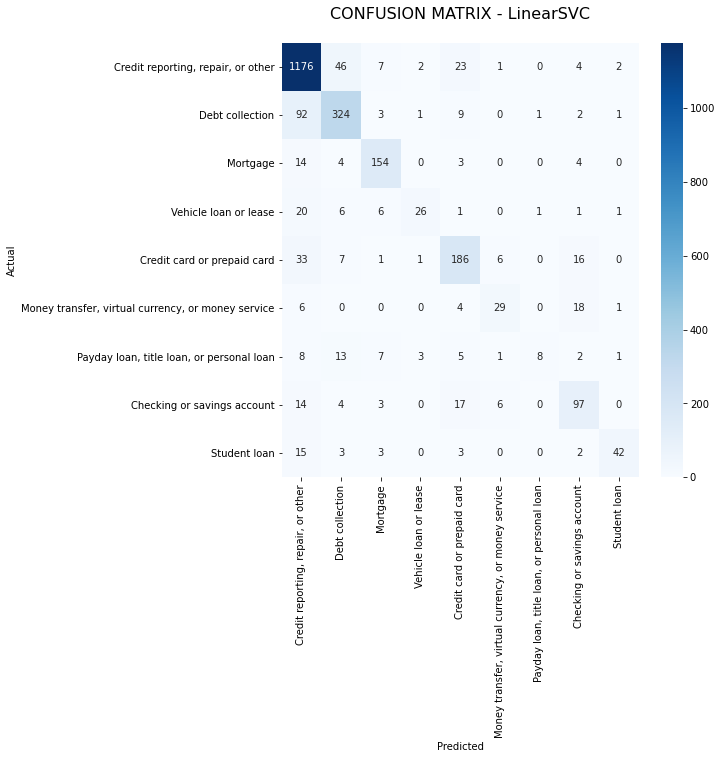

In [31]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

##### Observation:
The model is doing well overall bu there is some products wich are harder to predict than other. Those harder labels are:
- Vehicle loan or lease
- Money transfer, virtual currency, or money service
- Payday loan, title loan, or personal loan 